# Error metrics
Conda environment: `time-series`   
27 Jun 2024

In [1]:
import os

os.chdir("/Users/razielar/Documents/git_rep/personal_repos/forecasting_with_ml/")

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

from src.error_metrics import forecast_bias, WAPE

/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [4]:
# Load the data
data = fetch_dataset(name="store_sales", raw=True)
data

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


## 2) Preprocessing

In [5]:
# Data preprocessing
selected_store = 2
selected_items = data.item.unique()  # All items
# selected_items = [1, 2, 3, 4, 5] # Selection of items to reduce computation time

# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")

# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily.
# This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()

data

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.0000,74.0000,88.0000,72.0000,22.0000,101.0000,90.0000,44.0000,72.0000,50.0000,56.0000,25.0000,78.0000,93.0000,38.0000,110.0000,49.0000,36.0000,20.0000,56.0000,59.0000,37.0000,91.0000,78.0000,33.0000,56.0000,33.0000,67.0000


In [6]:
# Check if any missing values introduced
data.isnull().sum().any()

False

## 3) EDA

/var/folders/fd/vdpcq4tn1v3fbxg5302hgb980000gq/T/ipykernel_3528/2505712224.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :NUM_ITEMS].plot(


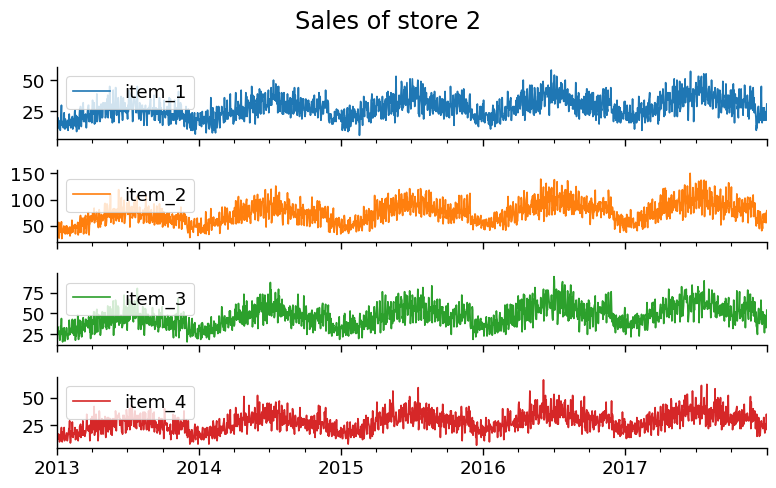

In [7]:
# Plot a subset of the time series
fig, ax = plt.subplots(figsize=(8, 5))

NUM_ITEMS = 4
data.iloc[:, :NUM_ITEMS].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    ax=ax,
)

plt.xlabel("")
fig.tight_layout()

In [8]:
data["day_of_week"] = data.index.weekday
data

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000,1
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000,2
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000,3
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000,4
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000,2
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000,3
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.0000,74.0000,88.0000,72.0000,22.0000,101.0000,90.0000,44.0000,72.0000,50.0000,56.0000,25.0000,78.0000,93.0000,38.0000,110.0000,49.0000,36.0000,20.0000,56.0000,59.0000,37.0000,91.0000,78.0000,33.0000,56.0000,33.0000,67.0000,4


### 3.1) Trend, outliers, seasonality, and intermittency

In [9]:
mean_sales_by_item = data.filter(like="item").mean()
mean_sales_by_item

item_1     28.1736
item_2     75.3165
item_3     46.9923
item_4     28.2349
item_5     23.5405
item_6     74.9452
item_7     75.0586
item_8     99.0904
item_9     65.4781
item_10    94.0975
item_11    89.3100
item_12    89.3505
item_13   107.9031
item_14    75.3598
item_15   112.5789
item_16    32.9502
item_17    42.5685
item_18   108.1172
item_19    51.8198
item_20    60.9781
item_21    51.7563
item_22   103.0099
item_23    37.5690
item_24    84.7826
item_25   103.4261
item_26    61.1035
item_27    28.3390
item_28   112.6380
item_29    88.9737
item_30    51.8253
item_31    75.2766
item_32    56.7552
item_33    89.3116
item_34    33.0915
item_35    84.6627
item_36    98.7705
item_37    37.3593
item_38   103.2492
item_39    56.1643
item_40    37.5706
item_41    28.0696
item_42    47.3680
item_43    65.7853
item_44    37.7859
item_45   103.3812
item_46    75.2196
item_47    28.1878
item_48    66.0285
item_49    37.7119
item_50    84.6221
dtype: float64

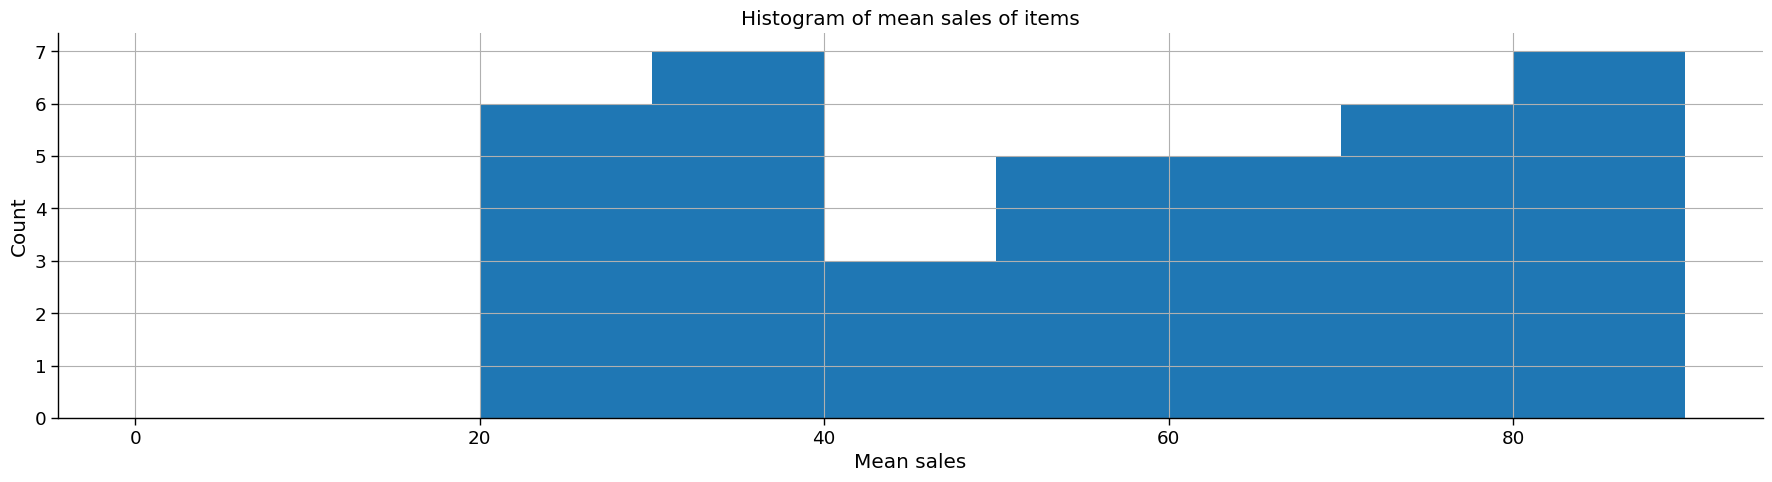

In [10]:
ax = mean_sales_by_item.hist(bins=np.arange(0, 100, 10))
ax.set_title("Histogram of mean sales of items")
ax.set_ylabel("Count")
ax.set_xlabel("Mean sales")

plt.show()

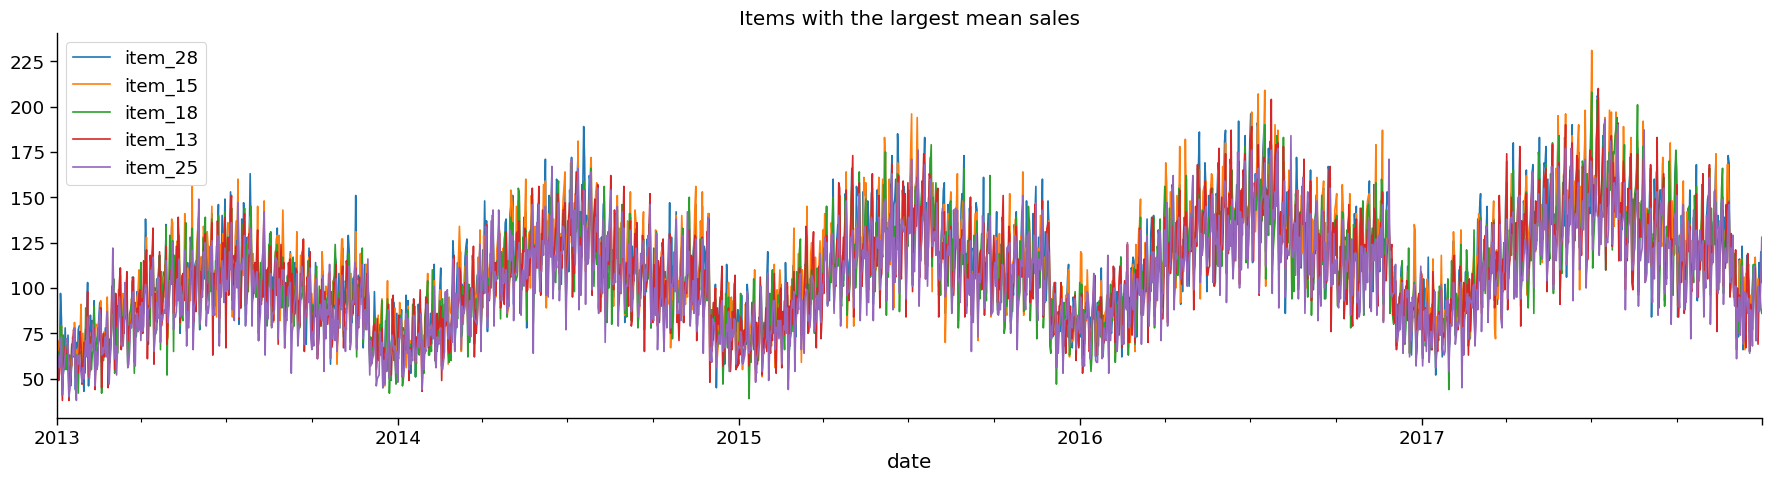

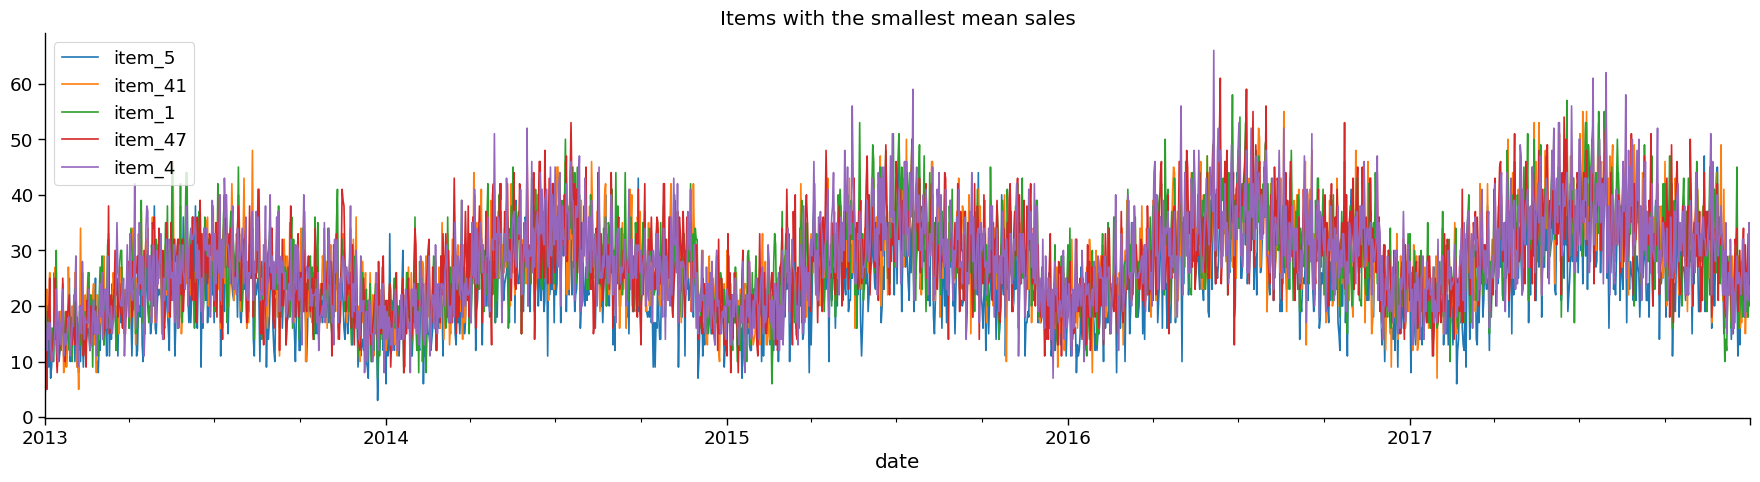

In [11]:
# The largest time series
largest_items = mean_sales_by_item.nlargest(5).index
ax = data.loc[:, largest_items].plot()
ax.set_title("Items with the largest mean sales")

# The smallest time series
smallest_items = mean_sales_by_item.nsmallest(5).index
ax = data.loc[:, smallest_items].plot()
ax.set_title("Items with the smallest mean sales")

plt.show()

In [12]:
(
data.filter(like="item") # Filter to columns referring to item sales
    .pipe(lambda df: df == 0) # Check if any values == 0
    .any()
    .values
    .sum() # Sum over all elements in dataframe to get total number of zeros
)

0

We have a dataset which has:
- Multiple time series which have vary in average value from ~20-90 (this is not a large spread, it's barely one order of magnitude)
- Trend
- Seasonality
- No intermittency or zero values

## 4) Recursive Multistep Forecasting
For multiple independent time series.

In [14]:
forecaster = ForecasterAutoregMultiSeries(
    regressor=Ridge(random_state=123),
    lags=31,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# Define column names of target variables
target_cols = data.filter(like="item_").columns

# Define column names of exogenous features
exog_features = ["day_of_week"]

# Forecast horizon & number of steps to move forecast origin
steps = 7

# Number of datapoints to test over
n_backtesting = steps * 5

# Initial training set size
initial_train_size = len(data) - n_backtesting

In [15]:
initial_train_size

1791

In [16]:
# Run backtesting
metric, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data[target_cols],
    exog=data[exog_features],
    initial_train_size=initial_train_size,
    steps=steps,
    metric=[forecast_bias, WAPE],
    fixed_train_size=False,
    refit=True,
    verbose=True,
    show_progress=True,
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1791
Number of observations used for backtesting: 35
    Number of folds: 5
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2013-01-01 00:00:00 -- 2017-11-26 00:00:00  (n=1791)
    Validation: 2017-11-27 00:00:00 -- 2017-12-03 00:00:00  (n=7)
Fold: 1
    Training:   2013-01-01 00:00:00 -- 2017-12-03 00:00:00  (n=1798)
    Validation: 2017-12-04 00:00:00 -- 2017-12-10 00:00:00  (n=7)
Fold: 2
    Training:   2013-01-01 00:00:00 -- 2017-12-10 00:00:00  (n=1805)
    Validation: 2017-12-11 00:00:00 -- 2017-12-17 00:00:00  (n=7)
Fold: 3
    Training:   2013-01-01 00:00:00 -- 2017-12-17 00:00:00  (n=1812)
    Validation: 2017-12-18 00:00:00 -- 2017-12-24 00:00:00  (n=7)
Fold: 4
    Training:   2013-01-01 00:00:00 -- 2017-12-24 00:00:00  (n=1819)
    Validation: 2017-12-25 00:00:00 -- 

100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


In [21]:
error_metric_names = ["forecast_bias", "WAPE"]
# Because we have a negative fb, we on average: Over Forecast
metric[error_metric_names].mean().reset_index(name="value").rename(columns={"index": "metric"})

,metric,value
0,forecast_bias,-0.0971
1,WAPE,0.1700


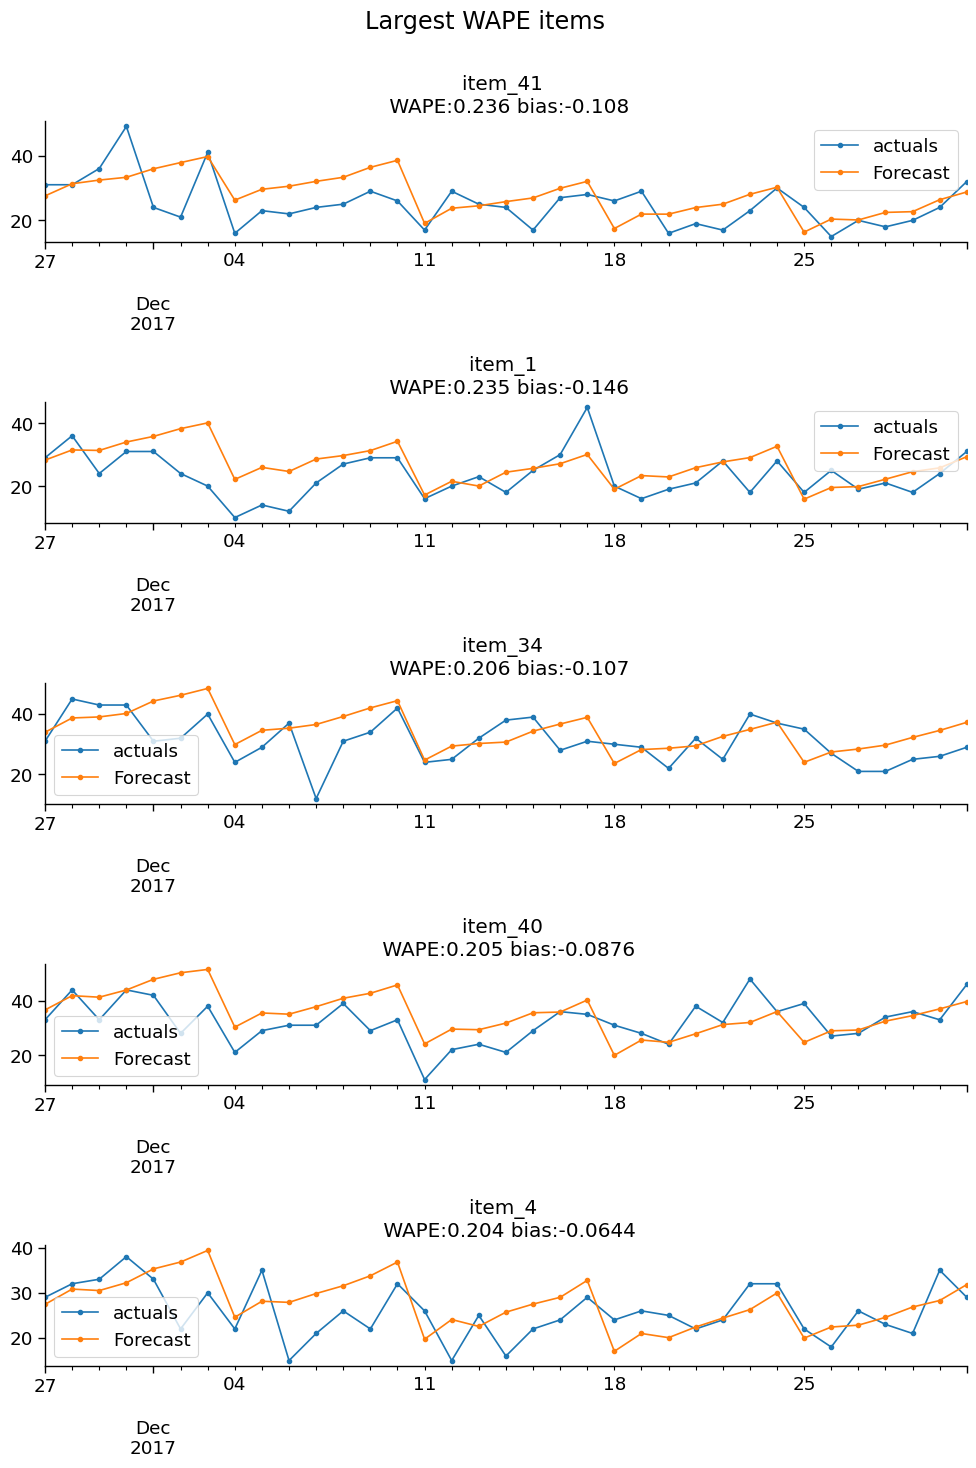

In [25]:
items_large_wape = metric.nlargest(n=5, columns=["WAPE"]).levels
backtest_period = predictions.index

n_series = len(items_large_wape)
fig, axs = plt.subplots(nrows=n_series, figsize=[10, n_series*3])

for ax, item in zip(axs, items_large_wape):
    wape = metric[metric["levels"]==item]["WAPE"].values[0]
    bias = metric[metric["levels"]==item]["forecast_bias"].values[0]
    (
        data
        .loc[backtest_period, item]
        .plot(ax=ax, label="actuals", marker="o", markersize=3)
    )
    (
        predictions
        .loc[:, item]
        .plot(ax=ax, label="Forecast", marker="o", markersize=3)
    )
    ax.set_title(f"{item} \n WAPE:{wape:.3} bias:{bias:.3}")
    ax.legend()

fig.suptitle("Largest WAPE items \n")
plt.tight_layout()

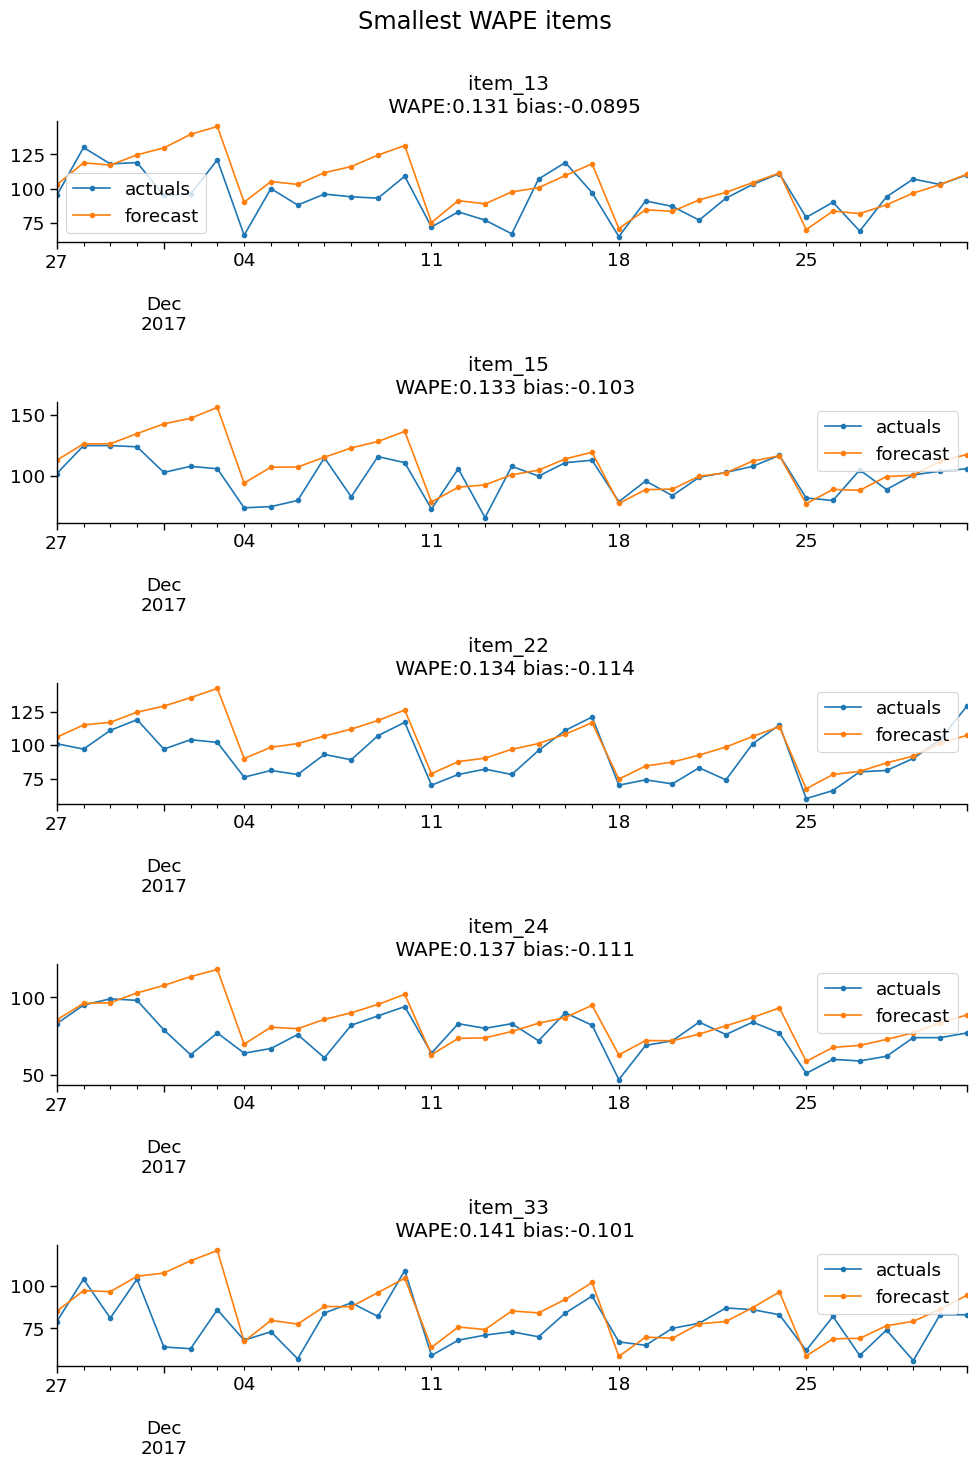

In [28]:
items_small_wape = metric.nsmallest(n=5, columns=["WAPE"]).levels
backtest_period = predictions.index

n_series = len(items_small_wape)
fig, axs = plt.subplots(nrows=n_series, figsize=[10, n_series*3])

for ax, item in zip(axs, items_small_wape):
    wape = metric[metric["levels"]==item]["WAPE"].values[0]
    bias = metric[metric["levels"]==item]["forecast_bias"].values[0]
    (
        data
        .loc[backtest_period, item]
        .plot(ax=ax, label="actuals", marker="o", markersize=3)
    )
    (
        predictions
        .loc[:, item]
        .plot(ax=ax, label="forecast", marker="o", markersize=3)
    )
    ax.set_title(f"{item} \n WAPE:{wape:.3} bias:{bias:.3}")
    ax.legend()

fig.suptitle("Smallest WAPE items \n")
plt.tight_layout()